In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

In [ ]:
!kaggle datasets download -d lngcthun/utkface-convert-csv

utkface-convert-csv.zip: Skipping, found more recently modified local copy (use --force to force download)


##Image dataset

In [ ]:
#Image dataset
!kaggle datasets download -d jangedoo/utkface-new

utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

# Define the path to your zip file
file_path = '/content/utkface-new.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
path = Path("/content/UTKFace")
filenames = [file.name for file in path.glob('*.jpg')]

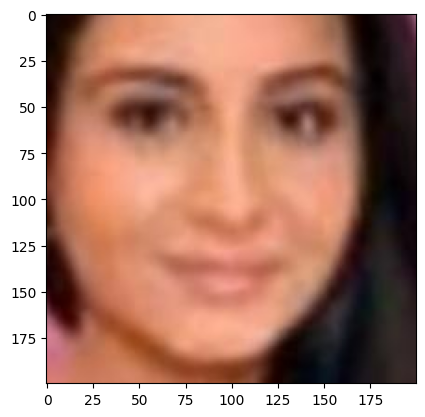

In [ ]:
img = Image.open("/content/UTKFace/" + filenames[1])
plt.imshow(img)
plt.show()


In [ ]:
class UTKFaceDataset(Dataset):
    def __init__(
        self,
        dataset_path,
        size=(64, 64),
        device="cpu",
    ):
        self.dataset_path = dataset_path
        self.size = size
        self.device = device

        images = []
        genders = []


        for i in os.listdir(self.dataset_path)[0:8000]:
            split = i.split('_')
            genders.append(int(split[1]))
            images.append(os.path.join(self.dataset_path, i))

        self.df = pd.DataFrame({"Image": images, "Genders": genders})

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = self.df.iloc[index]["Image"]
        image = torchvision.io.read_image(image_path)

        image = image.to(self.device)
        image = transforms.Resize(self.size, antialias=True)(image)
        image = image / 255.0

        label = torch.tensor([self.df.iloc[index]["Genders"]], dtype=torch.float32)

        return image, label

In [ ]:
dataset = UTKFaceDataset(dataset_path='/content/UTKFace', size=(64, 64))


In [ ]:
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [0.6,0.2, 0.2]
)

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvDenseVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(ConvDenseVariationalAutoencoder, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.encoder_dense1 = nn.Linear(128 * 6 * 6, 512)
        self.encoder_dense2 = nn.Linear(512, latent_dims)
        # self.encoder_dense3 = nn.Linear(512, latent_dims)

        # Decoder layers
        self.decoder_dense1 = nn.Linear(latent_dims, 512)
        self.decoder_dense2 = nn.Linear(512, 128 * 6 * 6)
        self.decoder_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.decoder_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

        # Normal distribution for sampling
        self.N = torch.distributions.Normal(0, 1)
        if torch.cuda.is_available():
            self.N.loc = self.N.loc.cuda()  # Move to GPU
            self.N.scale = self.N.scale.cuda()

        # KL divergence placeholder
        self.kl = 0


    def encode(self, x):
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))
        x = F.relu(self.encoder_conv3(x))

        # Adjust the flattening operation to match the size after the convolutions
        x = torch.flatten(x, start_dim=1)

        # Reshape x to match the expected input size for encoder_dense1
        x = x.view(-1, 128 * 6 * 6)

        x = F.relu(self.encoder_dense1(x))
        mu = self.encoder_dense2(x)
        sigma = torch.exp(self.encoder_dense2(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

    def decode(self, z):
        x = F.relu(self.decoder_dense1(z))
        x = F.relu(self.decoder_dense2(x))
        x = x.view(-1, 128, 6, 6)  # Reshape to match the size after the dense layers

        # Adjust the size to match the expected input size for the linear layer
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)

        # Use a different interpolation for the final layer to match the desired output size
        x = F.interpolate(x, size=(96, 96), mode='bilinear', align_corners=False)

        x = F.relu(self.decoder_conv1(x))
        x = F.relu(self.decoder_conv2(x))
        reconstructed_x = torch.sigmoid(self.decoder_conv3(x))
        return reconstructed_x


    def forward(self, x):
        z = self.encode(x)
        reconstructed_x = self.decode(z)
        return reconstructed_x


def train(autoencoder, dataloader, epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder = autoencoder.to(device)

    optimizer = torch.optim.Adam(autoencoder.parameters())

    for epoch in range(epochs):
        total_loss = 0.0
        autoencoder.train()

        for batch_data, label in dataloader:
            x = batch_data.to(device)

            # Resize input images to match the expected size
            x = F.interpolate(x, size=(96, 96), mode='bilinear', align_corners=False)
            print(f'shape of x {x.shape}')
            # Ensure the batch size is consistent
            x_hat = autoencoder(x)

            optimizer.zero_grad()

            # Resize x_hat to match the size of x for MSE loss
            x_hat_resized = F.interpolate(x_hat, size=(96, 96), mode='bilinear', align_corners=False)
            print(f'shape of x_hat_resized {x_hat.shape}')
            # Calculate reconstruction loss
            reconstruction_loss = F.mse_loss(x_hat_resized, x, reduction='sum')

            # Add KL divergence term
            loss = reconstruction_loss + autoencoder.kl
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {average_loss:.4f}")

    return autoencoder

In [ ]:
latent_dims = 2
vae = ConvDenseVariationalAutoencoder(latent_dims)  # GPU
vae = train(vae, train_loader)

shape of x torch.Size([64, 3, 96, 96])


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.50 GiB. GPU 0 has a total capacty of 14.75 GiB of which 99.06 MiB is free. Process 7741 has 14.65 GiB memory in use. Of the allocated memory 6.94 GiB is allocated by PyTorch, and 7.58 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

##CSV DATASET


In [ ]:
import zipfile

# Define the path to your zip file
file_path = '/content/utkface-convert-csv.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split

#setting the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
df = pd.read_csv("/content/utkface_sortAge.csv")

In [ ]:
df

,Unnamed: 0,age,gender,ethnicity,image
0,2226,1,1,0,109 146 198 132 169 221 134 171 223 137 174 22...
1,2047,1,0,3,0 1 2 2 1 1 5 1 0 11 3 3 1 0 6 27 35 45 97 111...
2,2048,1,0,3,54 64 91 55 66 95 56 72 105 58 76 113 67 85 12...
3,2049,1,0,3,80 98 125 77 94 129 113 131 169 147 169 201 16...
4,2050,1,0,3,63 55 96 58 51 94 72 67 112 83 80 126 91 90 13...
...,...,...,...,...,...
23675,23536,99,1,0,218 233 242 216 228 238 200 216 232 161 181 20...
23676,1,100,0,0,136 125 121 136 126 122 126 120 115 91 86 81 6...
23677,10,100,1,2,34 104 171 31 105 169 36 109 170 34 100 161 45...
23678,3,100,1,0,93 82 78 93 82 78 93 82 78 93 82 78 93 82 78 9...


In [ ]:
df = df[:-28]

In [ ]:
# Convert Path objects to strings
#image_paths = [str(file) for file in filenames]

In [ ]:
#img = Image.open("/content/UTKFace/" + image_paths[1])
#plt.imshow(img)
#plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class PixelImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        pixel_data = self.dataframe.iloc[idx]['image']

        # Convert the pixel values to a numpy array and reshape it
        pixels = [int(pixel) for pixel in pixel_data.split()]

        # Ensure that the length is compatible with the desired shape
        if len(pixels) != 7500:
            raise ValueError(f"Invalid size for pixel values: {len(pixels)}. Expected size: 7500")

        # Reshape the tensor to the desired shape for a 50x150 grayscale image
        pixels = torch.tensor(pixels, dtype=torch.float32).view(1, 50, 150)

        # Apply the transform only if it's not already a tensor
        if self.transform and not isinstance(pixels, torch.Tensor):
            pixels = self.transform(pixels)

        return pixels


dataset1 = PixelImageDataset(df)


In [ ]:
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(
    dataset1, [0.6,0.2, 0.2]
)

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvDenseVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(ConvDenseVariationalAutoencoder, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.encoder_dense1 = nn.Linear(128 * 6 * 6, 512)
        self.encoder_dense2 = nn.Linear(512, latent_dims)
        self.encoder_dense3 = nn.Linear(512, latent_dims)

        # Decoder layers
        self.decoder_dense1 = nn.Linear(latent_dims, 512)
        self.decoder_dense2 = nn.Linear(512, 128 * 6 * 6)
        self.decoder_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.decoder_conv3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

        # Normal distribution for sampling
        self.N = torch.distributions.Normal(0, 1)
        if torch.cuda.is_available():
            self.N.loc = self.N.loc.cuda()  # Move to GPU
            self.N.scale = self.N.scale.cuda()

        # KL divergence placeholder
        self.kl = 0


    def encode(self, x):
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))
        x = F.relu(self.encoder_conv3(x))

        # Adjust the flattening operation to match the size after the convolutions
        x = torch.flatten(x, start_dim=1)

        # Reshape x to match the expected input size for encoder_dense1
        x = x.view(-1, 128 * 6 * 6)

        x = F.relu(self.encoder_dense1(x))
        mu = self.encoder_dense2(x)
        sigma = torch.exp(self.encoder_dense3(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

    def decode(self, z):
        x = F.relu(self.decoder_dense1(z))
        x = F.relu(self.decoder_dense2(x))
        x = x.view(-1, 128, 6, 6)  # Reshape to match the size after the dense layers

        # Adjust the size to match the expected input size for the linear layer
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)

        x = F.relu(self.decoder_conv1(x))
        x = F.relu(self.decoder_conv2(x))
        reconstructed_x = torch.sigmoid(self.decoder_conv3(x))
        return reconstructed_x


    def forward(self, x):
        z = self.encode(x)
        reconstructed_x = self.decode(z)
        return reconstructed_x



In [ ]:
BB007import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvDenseVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(ConvDenseVariationalAutoencoder, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.encoder_dense1 = nn.Linear(128 * 6 * 6, 512)
        self.encoder_dense2 = nn.Linear(512, latent_dims)
        # self.encoder_dense3 = nn.Linear(512, latent_dims)

        # Decoder layers
        self.decoder_dense1 = nn.Linear(latent_dims, 512)
        self.decoder_dense2 = nn.Linear(512, 128 * 6 * 6)
        self.decoder_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.decoder_conv3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

        # Normal distribution for sampling
        self.N = torch.distributions.Normal(0, 1)
        if torch.cuda.is_available():
            self.N.loc = self.N.loc.cuda()  # Move to GPU
            self.N.scale = self.N.scale.cuda()

        # KL divergence placeholder
        self.kl = 0


    def encode(self, x):
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))
        x = F.relu(self.encoder_conv3(x))

        # Adjust the flattening operation to match the size after the convolutions
        x = torch.flatten(x, start_dim=1)

        # Reshape x to match the expected input size for encoder_dense1
        x = x.view(-1, 128 * 6 * 6)

        x = F.relu(self.encoder_dense1(x))
        mu = self.encoder_dense2(x)
        sigma = torch.exp(self.encoder_dense2(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

    def decode(self, z):
        x = F.relu(self.decoder_dense1(z))
        x = F.relu(self.decoder_dense2(x))
        x = x.view(-1, 128, 6, 6)  # Reshape to match the size after the dense layers

        # Adjust the size to match the expected input size for the linear layer
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)

        # Use a different interpolation for the final layer to match the desired output size
        x = F.interpolate(x, size=(96, 96), mode='bilinear', align_corners=False)

        x = F.relu(self.decoder_conv1(x))
        x = F.relu(self.decoder_conv2(x))
        reconstructed_x = torch.sigmoid(self.decoder_conv3(x))
        return reconstructed_x


    def forward(self, x):
        z = self.encode(x)
        reconstructed_x = self.decode(z)
        return reconstructed_x


def train(autoencoder, dataloader, epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder = autoencoder.to(device)

    optimizer = torch.optim.Adam(autoencoder.parameters())

    for epoch in range(epochs):
        total_loss = 0.0
        autoencoder.train()

        for batch_data in dataloader:
            x = batch_data.to(device)

            # Resize input images to match the expected size
            x = F.interpolate(x, size=(96, 96), mode='bilinear', align_corners=False)
            print(f'shape of x {x.shape}')
            # Ensure the batch size is consistent
            x_hat = autoencoder(x)

            optimizer.zero_grad()

            # Resize x_hat to match the size of x for MSE loss
            x_hat_resized = F.interpolate(x_hat, size=(96, 96), mode='bilinear', align_corners=False)
            print(f'shape of x_hat_resized {x_hat.shape}')
            # Calculate reconstruction loss
            reconstruction_loss = F.mse_loss(x_hat_resized, x, reduction='sum')

            # Add KL divergence term
            loss = reconstruction_loss + autoencoder.kl
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {average_loss:.4f}")

    return autoencoder


In [ ]:
latent_dims = 2
vae = ConvDenseVariationalAutoencoder(latent_dims)  # GPU
vae = train(vae, train_loader)

shape of x torch.Size([64, 1, 96, 96])
shape of x_hat_resized torch.Size([256, 1, 768, 768])


<ipython-input-18-871349cd0ecf>:100: UserWarning: Using a target size (torch.Size([64, 1, 96, 96])) that is different to the input size (torch.Size([256, 1, 96, 96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  reconstruction_loss = F.mse_loss(x_hat_resized, x, reduction='sum')


RuntimeError: The size of tensor a (256) must match the size of tensor b (64) at non-singleton dimension 0

In [ ]:
#Define model
latent_dims = 2
vae = ConvDenseVariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, train_loader)

In [ ]:


#Loss fuction
criterion = torch.nn.MSELoss(reduction='sum')

#Optimizer with lr 1e-3
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
